# 실습 준비

## python 3.6 필요
pyton 3.5에서는 작동하지 않음.

In [1]:
import sys
print( sys.version )

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


## Google Driver와 Colab 연동

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## 실행위치 이동

In [2]:
# 현재 위치
!pwd

# 실행위치 이동
%cd "/content/gdrive/My Drive/04_영상인식_copied/CH11"

# 이동된 위치 확인
!pwd
!ls -al

/content
/content/gdrive/My Drive/04_영상인식_copied/CH11
/content/gdrive/My Drive/04_영상인식_copied/CH11
total 12
drwx------  2 root root 4096 Feb 15 08:04 .ipynb_checkpoints
drwx------  2 root root 4096 Feb 15 07:40 output
drwx------ 11 root root 4096 Feb 15 07:27 super-resolution


# WDSR과 SRGAN으로 이미지 강화

## Keras 코드 다운로드
다음 주소의 코드를 다운 받는다.
 - 원본 주소 : https://github.com/krasserm/super-resolution

In [3]:
# 현재 위치
!pwd

# 다운로드
!if [ -d noise2noise ]; \
  then echo 'exists'; \
  else git clone https://github.com/krasserm/super-resolution.git; \
 fi

# 다운로드된 폴더로 이동
%cd super-resolution

# 이동된 위치 확인
!pwd

# 폴더 내용 확인
!ls -al

/content/gdrive/My Drive/04_영상인식_copied/CH11
fatal: destination path 'super-resolution' already exists and is not an empty directory.
/content/gdrive/My Drive/04_영상인식_copied/CH11/super-resolution
/content/gdrive/My Drive/04_영상인식_copied/CH11/super-resolution
total 7106382
-rw------- 1 root root       1242 Feb 15 07:27 callback.py
-rw------- 1 root root       2262 Feb 15 07:27 convert.py
-rw------- 1 root root       5691 Feb 15 07:27 data.py
drwx------ 2 root root       4096 Feb 15 07:27 demo
-rw------- 1 root root       1892 Feb 15 07:27 demo.py
-rw------- 1 root root 7276823415 Feb 18 07:55 DIV2K.zip
drwx------ 2 root root       4096 Feb 15 07:27 docs
-rw------- 1 root root         93 Feb 15 07:27 environment-cpu.yml
-rw------- 1 root root         97 Feb 15 07:27 environment-gpu.yml
-rw------- 1 root root        357 Feb 18 02:07 eval.json
-rw------- 1 root root       3103 Feb 15 07:27 evaluate.py
drwx------ 2 root root       4096 Feb 15 07:27 .git
-rw------- 1 r

## 파일 다운로드 함수 정의

구글 드라이브에서 공유된 파일을 다운로드할 수 있는 함수를 정의한다.

 - download_file_from_google_drive(id, destination) : id는 공유 링크의 id, destination은 파일명

In [0]:
import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

## 이미지 강화 모델 파일 다운로드

Google Drive에서 DIV2K 데이터로 이미 학습되어 공개된 모델 파일을 model 폴더 밑에 다운로드한다.
 - model/wdsr-a-32-x4-psnr-29.1736.h5 : 미리 학습된 WDSR 모델
 - model/edsr-16-x2-psnr-34.6356.h5 : 미리 학습된 EDSR 모델
 - model/edsr-16-x4-gen-epoch-088.h5 : 미리 학습된 SRGAN 모델

In [0]:
# 만약 기존 것이 있다면 삭제
!rm -rf ./model/wdsr-a-32-x4-psnr-29.1736.h5
!rm -rf ./model/edsr-16-x2-psnr-34.6356.h5
!rm -rf ./model/edsr-16-x4-gen-epoch-088.h5

# 구글 드라이브 파일을 다운로드
print('다운로드 시작...')
download_file_from_google_drive('1kgCedQEtp9xFZibayRQvkPaPT6SRh5BP', './model/wdsr-a-32-x4-psnr-29.1736.h5')  # WDSR 학습된모델
download_file_from_google_drive('1bNRmbvhZUNtdLtWTzTNB9H9tqMfk9ITA', './model/edsr-16-x4-gen-epoch-088.h5') # SRGAN 학습된모델
print('다운로드 완료.')

다운로드 시작...
다운로드 완료.


## DIV2K 데이터 다운로드

이미지 강화, 복원 및 초해상도 챌린지인 NTIRE 2017 대회에서 제공하는 데이터셋

train 데이터는 800개의 고해상도 이미지 파일과 이에 해당하는 저해상도 이미지 파일들로 구성되어있다.

validation 데이터는 100개의 고해상도 이미지 파일과 이에 해당하는 저해상도 이미지 파일들로 구성되어있다.

저해상도 이미지 파일을 얻기 위해 표준 Bicubic과 Unknown Downscaling 사용하였다.

bicubic interpolation

이미지를 기하학적으로 변환할 때, 원본에 아무런 영향을 받지 못하는 픽셀(pixel)이 생길 수 있다. 이 픽셀값을 얻기 위해 인접한 16개의 화소값을 사용하는 것을 bicubic interpolation이라 한다.

Unknown Downscaling

Unknown Downscaling에 대한 자세한 방법은 공개되지 않았다.


 - DIV2K.zip : 고해상도와 저해상도 이미지 데이터셋
 
 원본 주소에서는 고해상도와 저해상도 이미지를 각각 제공한다.
 
 - 원본 : https://data.vision.ee.ethz.ch/cvl/DIV2K

In [8]:
# 만약 기존 것이 있다면 삭제
!rm -rf ./DIV2K.zip

# 구글 드라이브 파일을 다운로드
print('다운로드 시작...')
download_file_from_google_drive('1yNVgvHs-FXP4A5JQ1eEQM4EcbXjKRaVY', 'DIV2K.zip') # 데이터셋(DIV2K)
print('다운로드 완료.')

다운로드 시작...
다운로드 완료.


## 압축해제

압축해제시 구글 드라이브와 싱크가 불안정하여 발생되는 이미지 소실을 방지하기 위해 /tmp 폴더 밑으로 압축해제

/tmp 폴더는 구글 드라이브 밖에 콘테이너 환경으로 런타임 재설정시 사라진다.

In [9]:
# 만약 기존 것이 있다면 삭제
!rm -rf /tmp/DIV2K

# tmp 폴더 밑에 데이터셋 압축 해제
!unzip DIV2K.zip -d /tmp/DIV2K

# 파일 확인
!echo /tmp
!ls -al /tmp

# 폴더 구조 확인
!echo; echo /tmp/DIV2K
!ls -al /tmp/DIV2K

# train 데이터는 800개의 고해상도(HR) 이미지 파일이 있다.
!echo; echo /tmp/DIV2K/DIV2K_train_HR
!ls -al /tmp/DIV2K/DIV2K_train_HR | head -10

# train 데이터 이미지로 Bicubic Downscaling(X1배)을 사용한 저해상도(LR) 이미지 파일
!echo; echo /tmp/DIV2K/DIV2K_train_LR_bicubic
!ls -al /tmp/DIV2K/DIV2K_train_LR_bicubic

# Bicubic Downscaling(X4배)한 이미지 파일
!echo; echo /tmp/DIV2K/DIV2K_train_LR_bicubic/X4
!ls -al /tmp/DIV2K/DIV2K_train_LR_bicubic/X4 | head -10

# validation 데이터는 폴더당 100개의 이미지 파일이 있다.
!echo; echo /tmp/DIV2K/DIV2K_valid_HR
!ls -al /tmp/DIV2K/DIV2K_valid_HR | head -10

# validation 데이터 이미지로 Bicubic Downscaling(X1배)한 이미지 파일
!echo; echo /tmp/DIV2K/DIV2K_valid_LR_bicubic
!ls -al /tmp/DIV2K/DIV2K_valid_LR_bicubic

# validation 데이터 이미지로 Bicubic Downscaling(X4배)한 이미지 파일
!echo; echo /tmp/DIV2K/DIV2K_valid_LR_bicubic/X4
!ls -al /tmp/DIV2K/DIV2K_valid_LR_bicubic/X4 | head -10

Archive:  DIV2K.zip
  inflating: /tmp/DIV2K/DIV2K_train_HR/0001.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0002.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0003.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0004.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0005.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0006.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0007.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0008.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0009.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0010.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0011.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0012.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0013.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0014.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0015.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0016.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0017.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0018.png  
  inflating: /tmp/DIV2K/DIV2K_train_HR/0019.png  
  inflating: /tmp/DIV2K/DIV2K_

# 이미지 강화

## 이미지 비교 함수 정의

In [0]:
def diffImage(ORG_IMG_PATH, RESULT_IMG_PATH):
    import matplotlib.pyplot as plt
    import imageio
    import os
    import numpy as np

    included_extensions = ['jpg','jpeg', 'bmp', 'png', 'gif']
    IMG_LIST = [ f for f in os.listdir(RESULT_IMG_PATH) if os.path.isfile(RESULT_IMG_PATH + '/' + f) ]

    print( RESULT_IMG_PATH, ' count:', len(IMG_LIST) )

    for result_img_path in IMG_LIST:

        result_img = imageio.imread( RESULT_IMG_PATH + '/' + result_img_path )

        org_img_path = result_img_path.replace('-sr.png', '.png')
        org_img = imageio.imread( ORG_IMG_PATH + '/' + org_img_path )

        plt.figure(figsize=(15,15))

        plt.subplot(121)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.grid(False)
        plt.title( org_img_path + str(org_img.shape) )
        plt.imshow(org_img)

        plt.subplot(122)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.grid(False)
        plt.title( result_img_path + str(result_img.shape) )
        plt.imshow(result_img)

        plt.show()

def diffImage2(ORG_IMG_PATH, RESULT_IMG_PATH, RESULT_IMG_PATH2):
    import matplotlib.pyplot as plt
    import imageio
    import os
    import numpy as np

    IMG_LIST = [ f for f in os.listdir(RESULT_IMG_PATH) if os.path.isfile(RESULT_IMG_PATH + '/' + f) ]

    print( RESULT_IMG_PATH, ' count:', len(IMG_LIST) )

    for result_img_path in IMG_LIST:

        result_img = imageio.imread( RESULT_IMG_PATH + '/' + result_img_path )
        result_img2 = imageio.imread( RESULT_IMG_PATH2 + '/' + result_img_path )

        org_img_path = result_img_path.replace('-sr.png', '.png')
        org_img = imageio.imread( ORG_IMG_PATH + '/' + org_img_path )
        
        plt.figure(figsize=(28,28))

        plt.subplot(131)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.grid(False)
        plt.title( org_img_path + str(org_img.shape) )
        plt.imshow(org_img)

        plt.subplot(132)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.grid(False)
        plt.title( result_img_path + str(result_img.shape) )
        plt.imshow(result_img)

        plt.subplot(133)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.grid(False)
        plt.title( result_img_path + str(result_img2.shape) )
        plt.imshow(result_img2)

        plt.show()

## WDSR 데모(샘플) 테스트

In [0]:
# 만약 기존 것이 있다면 삭제
!rm -rf ./output/wdsr

# WDSR 모델에 대한 demo 테스트
!python demo.py -i ./demo/gan -o ./output/wdsr --model ./model/wdsr-a-32-x4-psnr-29.1736.h5

Using TensorFlow backend.
2019-02-18 00:34:35.576167: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-02-18 00:34:35.576627: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x32571e0 executing computations on platform Host. Devices:
2019-02-18 00:34:35.576682: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-02-18 00:34:35.755150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-18 00:34:35.755718: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x3256b00 executing computations on platform CUDA. Devices:
2019-02-18 00:34:35.755797: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2019-02-18 00:34:35.756241: I tensorflow/core/common_runtime/gpu/g

output/wdsr  count: 1


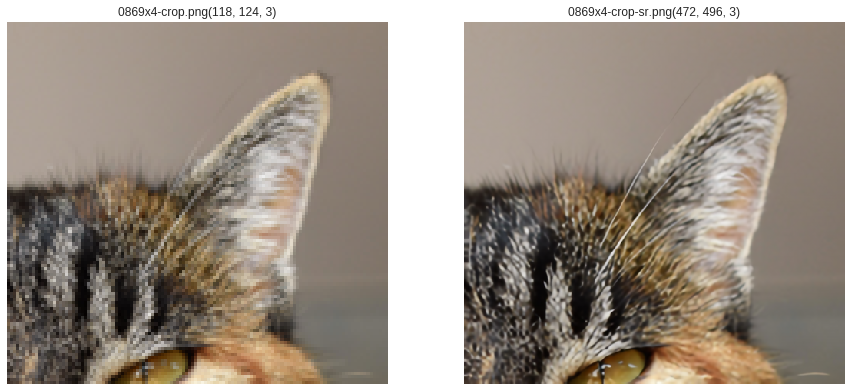

In [0]:
#좌측이미지: original
#우측이미지: predict output
ORG_IMG_PATH = './demo/gan'
RESULT_IMG_PATH = './output/wdsr'
diffImage( ORG_IMG_PATH, RESULT_IMG_PATH )

## SRGAN 데모(샘플) 테스트

In [0]:
# 만약 기존 것이 있다면 삭제
!rm -rf ./output/srgan

# SRGAN 모델에 대한 demo 테스트
!python demo.py -i ./demo/gan -o ./output/srgan --model ./model/edsr-16-x4-gen-epoch-088.h5

Using TensorFlow backend.
2019-02-19 06:40:14.922048: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-02-19 06:40:14.922281: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x33f51e0 executing computations on platform Host. Devices:
2019-02-19 06:40:14.922327: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-02-19 06:40:15.020843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-19 06:40:15.021429: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x33f4b00 executing computations on platform CUDA. Devices:
2019-02-19 06:40:15.021498: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2019-02-19 06:40:15.021900: I tensorflow/core/common_runtime/gpu/g

output/srgan  count: 1


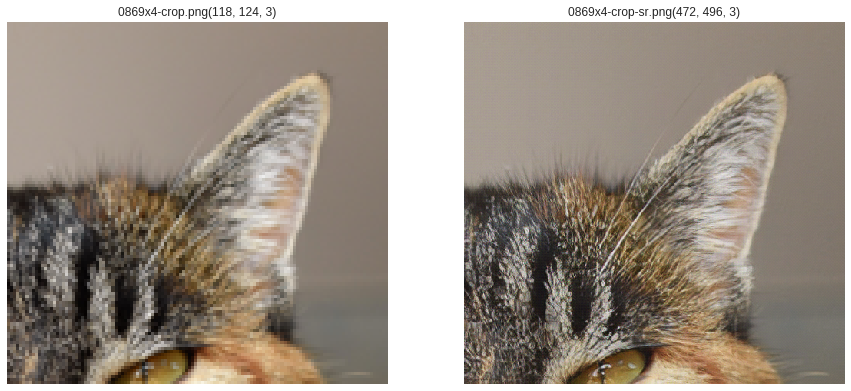

In [0]:
#좌측이미지: original
#우측이미지: predict output
ORG_IMG_PATH = './demo/gan'
RESULT_IMG_PATH = './output/srgan'
diffImage( ORG_IMG_PATH, RESULT_IMG_PATH )

## 원본 이미지 vs WDSR vs SRGAN 비교
 SRGAN이 WDSR과 EDSR에 비해 미세하게 나아 보임
 
 왼쪽부터 WDSR 모델로 예측한 이미지, EDSR 모델로 예측한 이미지,  SRGAN 모델로 예측한 이미지

output/wdsr  count: 1


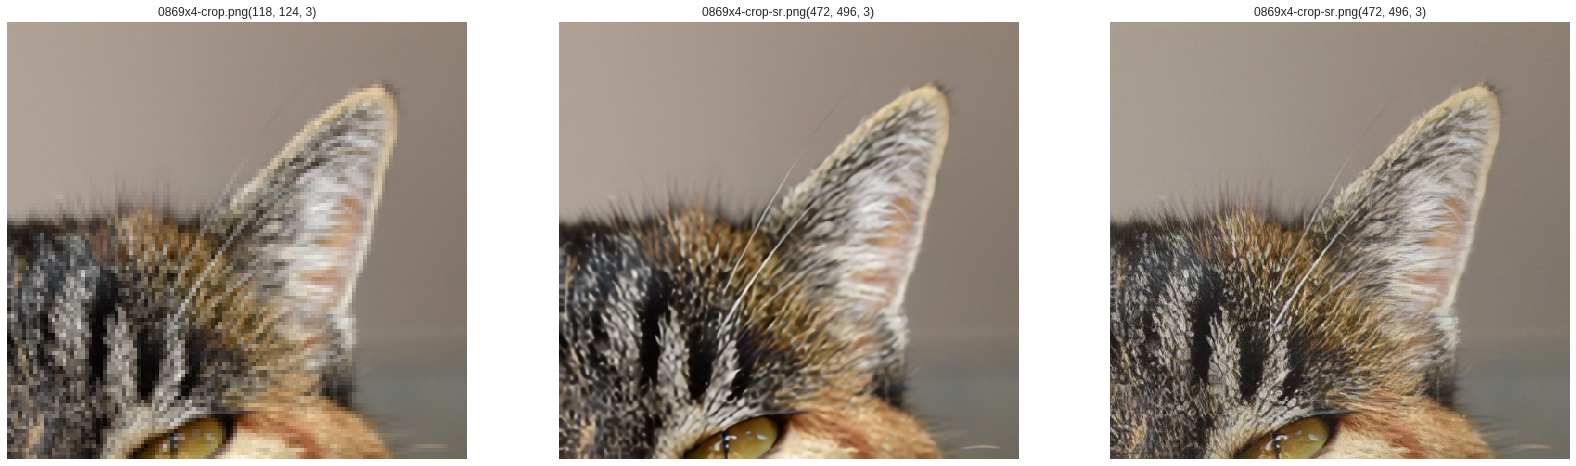

In [0]:
diffImage2('./demo/gan', './output/wdsr', './output/srgan')

# 학습 & 이미지 강화

## 데이터세트 변환
이미지를 미리 numpy array 형태로 변환 후 작업 시작

-i : 이미지 파일 경로

-o : 결과 파일 경로

전환 타입 : numpy로 설정

In [11]:
# 만약 기존 것이 있다면 삭제
!rm -rf /tmp/DIV2K_BIN

# 이미지를 numpy 형태로 변환
!python convert.py \
    -i /tmp/DIV2K \
    -o /tmp/DIV2K_BIN numpy

Using TensorFlow backend.
100% 1800/1800 [03:01<00:00,  9.90it/s]


## WDSR (Pixel-wise, wdsr-a-32-x4) 모델

### 미리 학습된 모델을 다운로드

In [0]:
download_file_from_google_drive('1rVHEoYUM9GEGRkCC-rU89QBYd64wmmo8', './model/wdsr-a-32-x2-psnr-34.8033.h5')

### 학습 시작
 - DIV2K 데이터 셋을 numpy array파일로 변환한 데이터로 학습  
 - train 데이터 : /tmp/DIV2K_BIN/DIV2K_train_LR_bicubic/X4 폴더, 800개의 .npy파일 
 - validation 데이터 : /tmp/DIV2K_BIN/DIV2K_valid_LR_bicubic/X4 폴더, 100개의 .npy파일

In [12]:
# 만약 기존 것이 있다면 삭제
!rm -rf output/train/wdsr

# 학습 결과를 저장할 폴더 생성
!mkdir -p output/train/wdsr

# train.py 실행
!python train.py \
    -d /tmp/DIV2K_BIN \
    -o ./output/train/wdsr \
    --profile wdsr-a-32 \
    --scale 4 \
    --res-expansion 6 \
    --epochs 5 \
    --pretrained-model ./model/wdsr-a-32-x2-psnr-34.8033.h5

Using TensorFlow backend.
2019-02-25 02:06:18.654056: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-02-25 02:06:18.657421: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x20ab1e0 executing computations on platform Host. Devices:
2019-02-25 02:06:18.657460: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-02-25 02:06:18.855098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-25 02:06:18.855661: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x20abe40 executing computations on platform CUDA. Devices:
2019-02-25 02:06:18.855714: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2019-02-25 02:06:18.856896: I tensorflow/core/common_runtime/gpu/g

### 가장 높은 val_psnr 모델을 가지고 이미지 강화

In [13]:
# 만약 기존 것이 있다면 삭제
!rm -rf ./output/wdsr5

# 학습한 모델로 실행
!python demo.py \
  -i ./demo/gan \
  -o ./output/wdsr5 \
  --model ./output/train/wdsr/20190225-020620/models/epoch-002-psnr-30.9111.h5

Using TensorFlow backend.
2019-02-25 03:55:42.417380: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-02-25 03:55:42.417693: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x30011e0 executing computations on platform Host. Devices:
2019-02-25 03:55:42.417739: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-02-25 03:55:42.595410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-25 03:55:42.595964: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x3001e40 executing computations on platform CUDA. Devices:
2019-02-25 03:55:42.596022: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2019-02-25 03:55:42.598420: I tensorflow/core/common_runtime/gpu/g

### 원본이미지 vs 학습한 WDSR vs 미리 학습된 WDSR 비교
- 좌측이미지 : 원본
- 중간이미지 : 5 epoch 결과 모델로 이미지 강화
- 우측이미지 : 미리 제공된 모델(충분히 학습된)로 이미지 강화

./output/wdsr5  count: 1


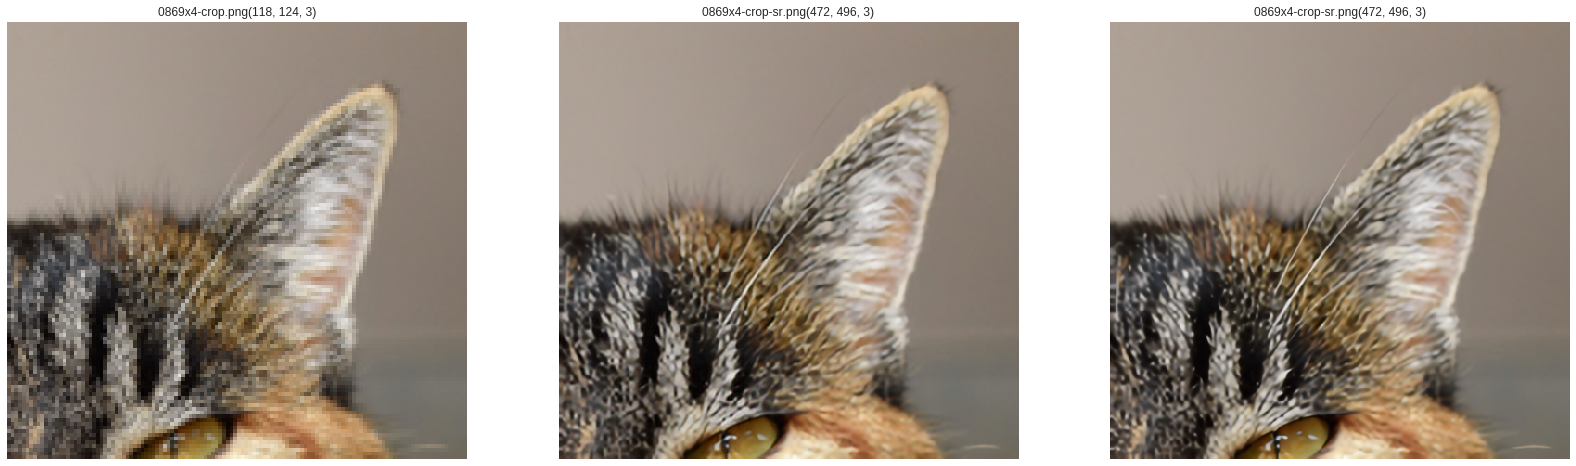

In [14]:
diffImage2('./demo/gan', './output/wdsr5', './output/wdsr')

## SRGAN
- SRGAN 모델에 EDSR 모델을 fine tuning

### 미리 학습된 모델을 다운로드

In [0]:
download_file_from_google_drive('1dZ2Ptnjr9-xwEXs4MJ4AQg6tqCOPgCaz', './model/edsr-16-x4-gen-pre-psnr-28.8885.h5')

### 학습 시작
 - DIV2K 데이터 셋을 numpy array파일로 변환한 데이터로 학습  
 - train 데이터 : /tmp/DIV2K_BIN/DIV2K_train_LR_bicubic/X4 폴더, 800개의 .npy파일 
 - validation 데이터 : /tmp/DIV2K_BIN/DIV2K_valid_LR_bicubic/X4 폴더, 100개의 .npy파일

In [16]:
# 만약 기존 것이 있다면 삭제
!rm -rf ./output/train/srgan

# 학습 결과를 저장할 폴더 생성
!mkdir -p ./output/train/srgan

# 학습 실행
!python train_gan.py \
    --dataset /tmp/DIV2K_BIN \
    --scale 4 \
    --num-res-blocks 16 \
    --outdir ./output/train/srgan \
    --generator edsr-gen \
    --pretrained-model ./model/edsr-16-x4-gen-pre-psnr-28.8885.h5 \
    --epochs 5

Using TensorFlow backend.
2019-02-25 04:56:25.156173: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-02-25 04:56:25.156496: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x1bef1e0 executing computations on platform Host. Devices:
2019-02-25 04:56:25.156541: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-02-25 04:56:25.253630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-25 04:56:25.254228: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x1beeb00 executing computations on platform CUDA. Devices:
2019-02-25 04:56:25.254284: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2019-02-25 04:56:25.254691: I tensorflow/core/common_runtime/gpu/g

### 가장 나은 평가를 받은 epoch의 결과 모델을 가지고 predict
- 좌측이미지 : 원본
- 중간이미지 : 5 epoch 결과 모델 predict 결과
- 우측이미지 : 미리 제공된 모델(충분히 학습된) predict 결과

In [17]:
# 만약 기존 것이 있다면 삭제
!rm -rf output/srgan5

# 학습한 모델로 실행
!python demo.py \
    -i ./demo/gan \
    -o ./output/srgan5 \
    --model ./output/train/srgan/20190225-045625/models/generator-epoch-004.h5

Using TensorFlow backend.
2019-02-25 06:03:08.910539: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-02-25 06:03:08.910814: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x27811e0 executing computations on platform Host. Devices:
2019-02-25 06:03:08.910860: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-02-25 06:03:09.016150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-25 06:03:09.016632: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x2781e40 executing computations on platform CUDA. Devices:
2019-02-25 06:03:09.016661: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2019-02-25 06:03:09.016982: I tensorflow/core/common_runtime/gpu/g

./output/srgan5  count: 1


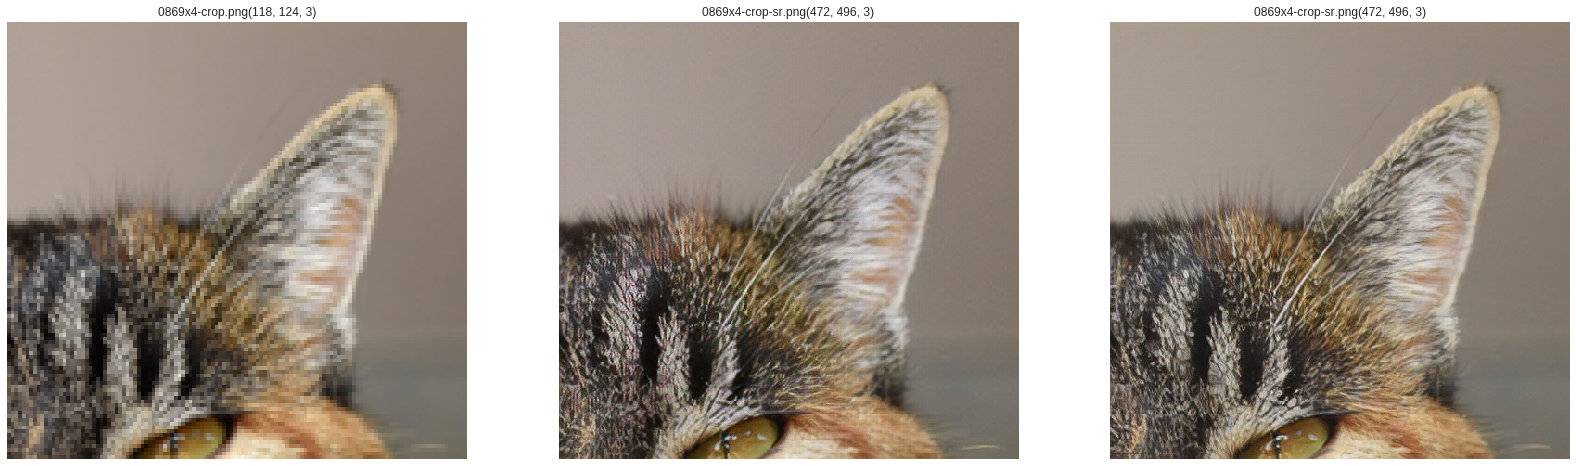

In [20]:
diffImage2('./demo/gan', './output/srgan5', './output/srgan')

# Image Enhancement 참고 자료

- Keras 코드 : https://github.com/krasserm/super-resolution

- DIV2K 데이터셋 : https://data.vision.ee.ethz.ch/cvl/DIV2K/

- DIV2K 데이터셋 설명 : http://www.vision.ee.ethz.ch/~timofter/publications/Agustsson-CVPRW-2017.pdf 